#### - Sobhan Moradian Daghigh
#### - 12/27/2021
#### - PR - EX02 - Q6 - All Parts

In [2]:
import numpy as np
from PIL import Image, ImageCms
import os, io
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import colour
import cv2

In [3]:
def get_data_paths(directory):
    filePaths = []
    for dirpath,_,filenames in os.walk(directory):
        for image_name in filenames:
            filePaths.append(os.path.abspath(os.path.join(dirpath, image_name))) 
    return filePaths

In [4]:
train = get_data_paths("./inputs/P6/pratheepan/train/set1/images")
train_masks = get_data_paths("./inputs/P6/pratheepan/train/set1/groundtruth")

### Part A.

In [5]:
skinPixelCounts = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]
noskinPixelCounts = [[[0 for k in range(256)] for j in range(256)] for i in range(256)]

# For next step, calculating the mean and covariance matrix
skin_list = []
noSkin_list = []

for i in range(len(train)):
    img = Image.open(train[i]).convert('RGB')
    mask = Image.open(train_masks[i]).convert('RGB')
    w, h = img.size
    
    for j in range(h):
        for i in range(w):
            red, green, blue = img.getpixel((i, j))
            maskRed, maskGreen, maskBlue = mask.getpixel((i, j))

            if(maskRed > 150 and maskGreen > 150 and maskBlue > 150):
                skinPixelCounts[red][green][blue] += 1
                skin_list.append([red, green, blue])
            else:
                noskinPixelCounts[red][green][blue] += 1
                noSkin_list.append([red, green, blue])
                
                
    img.close()
    mask.close()

In [6]:
def nested_sum(L):
    total = 0
    for i in L:
        if isinstance(i, list):
            total += nested_sum(i)
        else:
            total += i
    return total

In [7]:
# Skin Pixels Frequency
skin_count = nested_sum(skinPixelCounts)

In [8]:
# NoSkin Pixels Frequency
noSkin_count = nested_sum(noskinPixelCounts)

In [9]:
# Sum of pixels
pix_count = np.add(skin_count, noSkin_count)

#### Skin Prior Probability

In [10]:
skin_prior = round(np.divide(skin_count, pix_count), 3)
print(skin_prior)

0.275


#### NoSkin Prior Probability

In [11]:
noSkin_prior = round(np.divide(noSkin_count, pix_count), 3)
print(noSkin_prior)

0.725


### Part B.

In [12]:
def get_meanCov(datas):
    mean = np.divide([sum(x) for x in zip(*datas)], len(datas))
    # The dimention is too high, so Im not wanna calculate in matrix form
    # cov = np.matmul([np.subtract(x, mean) for x in datas], np.transpose([np.subtract(x, mean) for x in datas]))
    temp = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]
    for ele in datas:
        sub = np.subtract(ele, mean).reshape(3, 1)
        temp = np.add(temp, np.matmul(np.array(sub), np.transpose(np.array(sub))))
    cov = np.divide(temp, len(datas))
    return mean, cov

#### Skin Mean and Covariance

In [13]:
skin_mean, skin_cov = get_meanCov(skin_list)
print("Mean: \n{}".format(skin_mean))
print("\nCovariance: \n{}".format(skin_cov))

Mean: 
[ 189.93650938  140.48149646  111.69942265]

Covariance: 
[[ 1962.10616042  1953.49144369  1861.1339192 ]
 [ 1953.49144369  2383.49106594  2449.30086464]
 [ 1861.1339192   2449.30086464  2675.40603824]]


In [14]:
# Check for [det != 0] 
# If [det == 0], then its a singular Covariance and theres no inverse for it.
np.linalg.det(skin_cov)

85364096.300871387

#### NoSkin Mean and Covariance

In [15]:
noSkin_mean, noSkin_cov = get_meanCov(noSkin_list)
print("Mean: \n{}".format(noSkin_mean))
print("\nCovariance: \n{}".format(noSkin_cov))

Mean: 
[ 129.37221255  106.52092805   96.43530788]

Covariance: 
[[ 7762.2423282   6717.72306037  6294.89032932]
 [ 6717.72306037  7075.67355209  6916.65215675]
 [ 6294.89032932  6916.65215675  7145.14202326]]


In [16]:
# Check for [det != 0] 
# If [det == 0], then its a singular Covariance and theres no inverse for it.
np.linalg.det(noSkin_cov)

3237844884.8134179

### Part C.

In [17]:
# Continues with Noraml Distribution
def cal_probability_density(mean, cov, x):
    var = multivariate_normal(mean=mean, cov=cov)
    prob = var.pdf(x)
    return prob

In [18]:
def BC(skin_liklihood, noSkin_liklihood, thresh=0.0):
    predictions = []

    for skn, noSkn in zip(skin_liklihood, noSkin_liklihood):
        posteriors = []
        
        posteriors.append(np.add(np.add(np.log(skin_prior), np.log(skn)), np.log2((thresh * 10) + 1)))
        posteriors.append(np.add(np.log(noSkin_prior), np.log(noSkn)))
    
        idx = np.argmax(posteriors)
        predictions.append(0 if idx == 1 else 255)
        
    return predictions

In [276]:
def skinDetection(img_name, thresh=0.0):
    
    img = Image.open(img_name).convert('RGB')
    w, h = img.size
    blank = np.zeros((h, w), dtype=int)

    for j in range(h):
        skin_liklihood = cal_probability_density(skin_mean, skin_cov, np.array(img)[j])
        noSkin_liklihood = cal_probability_density(noSkin_mean, noSkin_cov, np.array(img)[j])
        blank[j] = BC(skin_liklihood, noSkin_liklihood, thresh)

    return blank

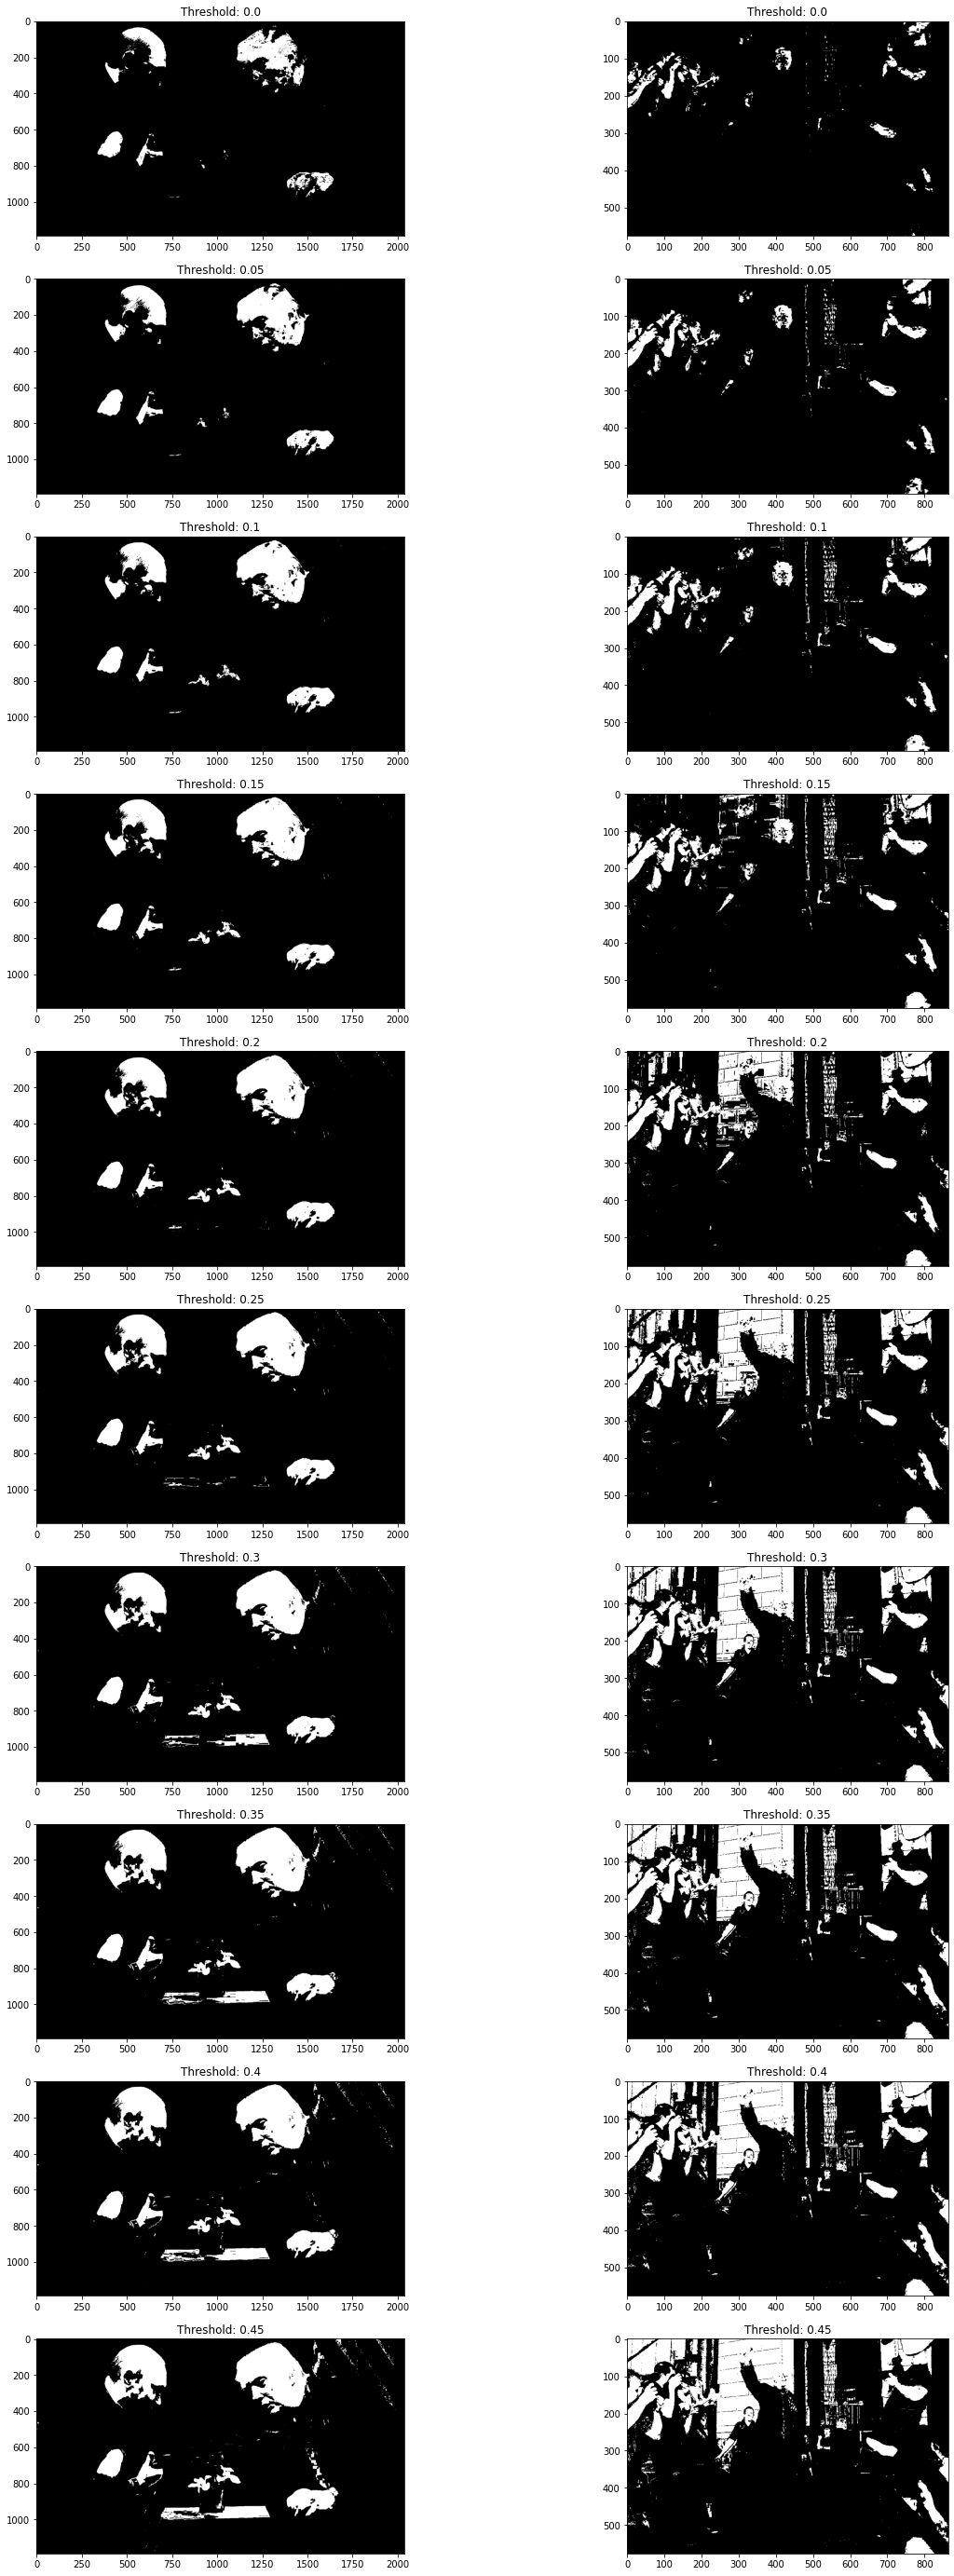

In [31]:
fig, ax = plt.subplots(10, 2, figsize=(12, 50))
images = ['trump_tie_1.jpg', 'trump_tie_2.jpg']

for i in range(2):
    img_name = './inputs/P6/{}'.format(images[i])
    idx = 0
    for thresh in np.arange(0.0, 0.5, 0.05):
        thresh = round(thresh, 2)
        blank = skinDetection(img_name, thresh)
        ax[idx, i].imshow(blank, cmap='gray')
        ax[idx, i].set_title('Threshold: {}'.format(thresh))
        idx += 1

plt.show()

### Part D.

In [20]:
skin_prototype = skin_mean
noSkin_prototype = noSkin_mean

In [21]:
def display_prototype(prototype):
    print("Skin prototype:")
    img = np.zeros([20,20,3],dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j] = prototype
    plot = plt.figure()
    plt.imshow(img)
    plt.show()

Skin prototype:


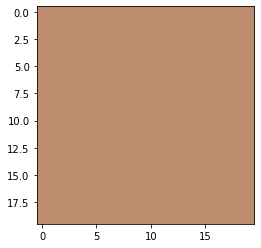

In [22]:
display_prototype(skin_prototype)

In [201]:
def cal_distance(img_name, prototypes):
    distances = []
    img = Image.open('./inputs/P6/{}'.format(img_name))
    w, h = img.size
    
    for proto in prototypes:
        mean = np.zeros([h, w, 3],dtype=np.uint8)
        for i in range(mean.shape[0]):
            for j in range(mean.shape[1]):
                mean[i][j] = proto

# ------- To have a perceptually uniform color space, we can convert RGB to Lab --------
#         mean_lab = cv2.cvtColor(mean.astype(np.float32) / 255, cv2.COLOR_RGB2Lab)
#         img_lab = cv2.cvtColor(img.astype(np.float32) / 255, cv2.COLOR_RGB2Lab)
#         delta_E = colour.delta_E(img_lab, mean_lab)
# --------------------------------------------------------------------------------------

        dis = np.linalg.norm(img - mean, axis=2)
        distances.append(dis)
        
    return distances, h, w

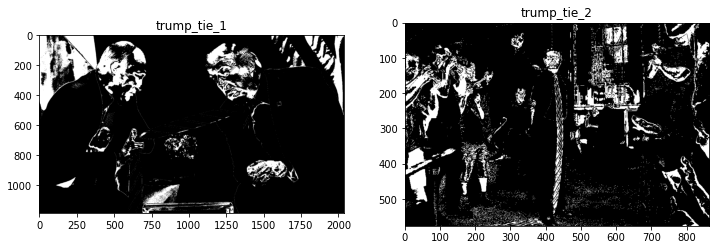

In [265]:
fig, ax = plt.subplots(1, 2, figsize=(12, 50))
images = ['trump_tie_1.jpg', 'trump_tie_2.jpg']

for k in range(2):
    distances, h, w = cal_distance(images[k], [skin_prototype, noSkin_prototype])
    blank = np.zeros((h, w), dtype=int)
    for j in range(0, h):
        for i in range(0, w):
            idx = np.argmin([distances[0][j][i] + 60, distances[1][j][i]])
            blank[j][i] = 0 if idx == 1 else 255
            
    ax[k].imshow(blank, cmap='gray')
    ax[k].set_title('{}'.format(images[k].split('.')[0]))

### Part E.

In [268]:
test = get_data_paths("./inputs/P6/pratheepan/test/images")
test_masks = get_data_paths("./inputs/P6/pratheepan/test/groundtruth")

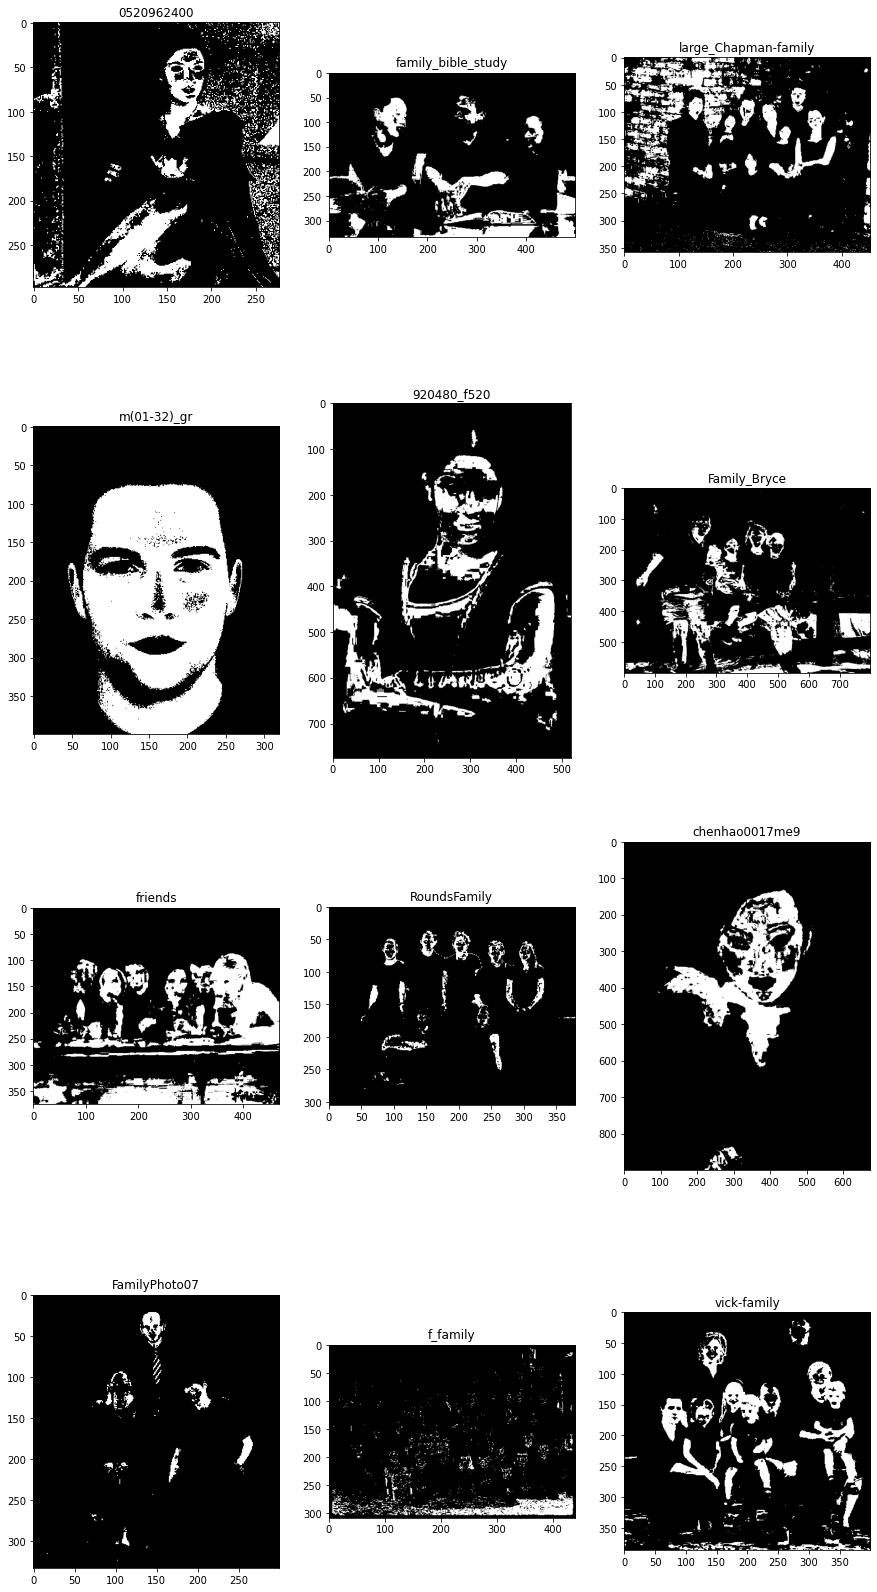

In [281]:
fig, ax = plt.subplots(4, 3, figsize=(15, 30))

for i in range(0, len(test)):
    img_name = test[i]
    blank = skinDetection(img_name)
    ax[np.mod(i, 4), np.remainder(i, 3)].imshow(blank, cmap='gray')
    ax[np.mod(i, 4), np.remainder(i, 3)].set_title('{}'.format(img_name.split('\\')[-1].split('.')[0]))

plt.show()

#### Some helpful stuffs

In [252]:
# a = np.array([[[100, 100, 100], [100, 100, 100]],
#               [[50, 100, 100], [100, 100, 100]]])

# b= np.array([[[100, 100, 100], [100, 100, 100]],
#              [[60, 110, 100], [100, 100, 50]]])

In [266]:
# np.linalg.norm(a - b, axis=2)

In [ ]:
# def srgb2lab(img):
#     srgb_p = ImageCms.createProfile("sRGB")
#     lab_p  = ImageCms.createProfile("LAB")
#     rgb2lab_trans = ImageCms.buildTransformFromOpenProfiles(srgb_p, lab_p, "RGB", "LAB")
#     lab2rgb_trans = ImageCms.buildTransformFromOpenProfiles(lab_p, srgb_p, "LAB", "RGB")
    
#     return ImageCms.applyTransform(img, self.rgb2lab_trans)

In [176]:
# Using srgb converter from [https://www.py4u.net/discuss/162866]
# def convert_to_srgb(img):
#     icc = img.info.get('icc_profile', '')
#     if icc:
#         io_handle = io.BytesIO(icc)
#         src_profile = ImageCms.ImageCmsProfile(io_handle)
#         dst_profile = ImageCms.createProfile('sRGB')
#         img = ImageCms.profileToProfile(img, src_profile, dst_profile)
#     return img